# Project: Heart Failure Prediction

This is the notebook corresponding to the Final Project of ECE 523 Engineering Applications of Machine Learning of The University of Arizona by Jeffin George Johnson and Reya Jijy Abraham

In [1]:
#Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc




In [2]:
#Reading data from file

data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# 1. Data Analysis and Visualisation

The boxplot below illustrates the relationship between age and heart disease. Overall the average age of patients without heart diease is 50 years old. The patients with heart disease have an average age of 55 for men and older for women


50.551219512195125


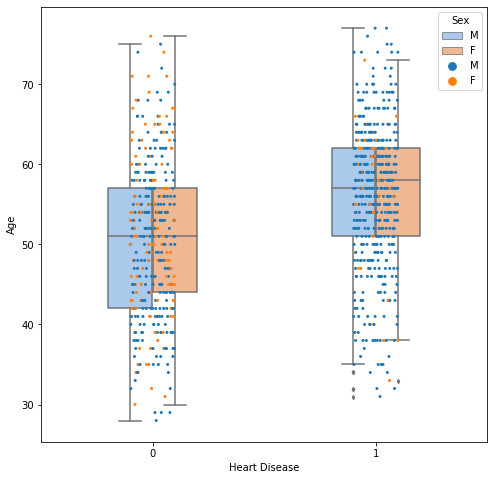

In [3]:


fig, ax = plt.subplots(figsize = (8, 8))
survive = data.loc[(data.HeartDisease == 0)].Age
death = data.loc[(data.HeartDisease == 1)].Age
print(survive.mean())

sns.boxplot(data = data, x = 'HeartDisease', y = 'Age', hue = 'Sex', width = 0.4, ax = ax, fliersize = 3, palette=sns.color_palette("pastel"))
sns.stripplot(data = data, x = 'HeartDisease', y = 'Age', hue = 'Sex', size = 3, palette=sns.color_palette())
ax.set(xlabel = 'Heart Disease', ylabel="Age")
plt.show()

## 1.2 Resting BP/Maximum Heart rate and Heart Disease

The violin plots display the relationship between `Resting BP`(left)/`Maximum Heart Rate`(right) and Heart Disease. On the right hand side, there is a significant difference in `MaxHR` between patients who have heart disease and patients who don't. On the other hand, in the chart on the left, there is no significant difference in the level of `RestingBP` between two types of patients. 

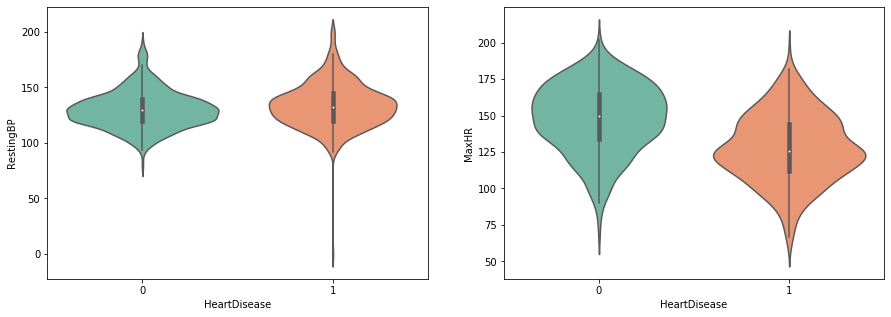

In [4]:
fig, ax = plt.subplots(ncols=2, figsize = (15, 5))
sns.violinplot(data=data, x='HeartDisease', y='RestingBP', ax=ax[0], palette=sns.color_palette('Set2'))
sns.violinplot(data=data, x='HeartDisease', y='MaxHR', ax=ax[1], palette=sns.color_palette('Set2'))

In [5]:
#Dropping the Y-label from the Dataset
numerical= data.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = data.select_dtypes('object').columns

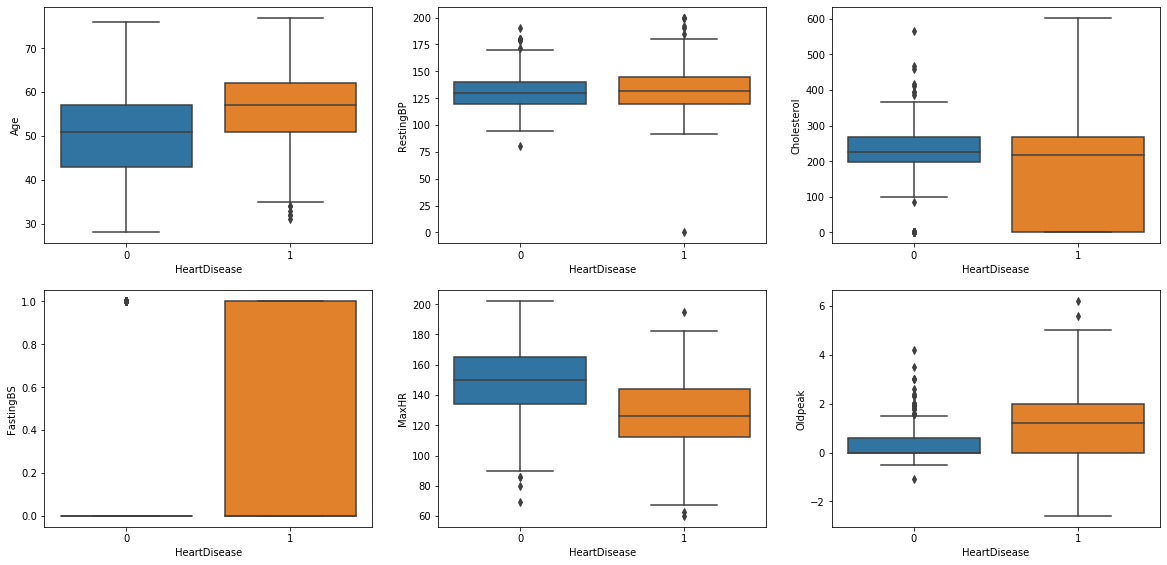

In [6]:
#Plotting the range of values of different features that is likely to cause Heart Disease

index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(4, 3, index)
        sns.boxplot(x='HeartDisease', y=feature, data=data)

# Correlation among variables using Heatmap:

The numbers below are the correlation between features and `Heart Disease`. The correlation close to 1.0 and -1.0 means the variable is positively and negatively correlated, respectively. The correlation close to 0 is less correlated. 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text xticklabel objects>)

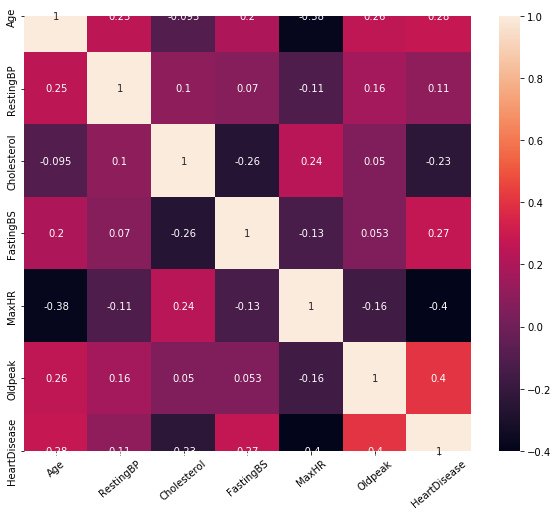

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True)
plt.xticks(rotation=40)

##  Data Cleaning
Data cleaning is the first step to prepare datasets to ensure that there is no missing values occurs during the application because most machine learning algorithms cannot work with missing features. Two common ways to deal with missing values are as follows:
* Get rid of data with missing values by using `dropna()`.
* Fill in some values to missing values by using `fillna()`. 

In [8]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Feature Scaling


Feature Scaling is a preprocessing to scale data to a standard range before building machine learning models. Without feature scaling, one significant number can impact the model because of its large magnitude. This results the model to suffer from poor performance during learning. 


###  Binary and Non-binary Data
Dataset contains both binary and non-binary values. We now call the binary as `discrete_features` and the non-binary as `continuous_features`. The standard deviation of `discrete_features` is already small, ranging between `0` and `1`, so we do not have to scale them. Unlike `continuous_features`, the standard deviation varies from `1.03` to `97,804`. Hence, we have to scale these features. We categorise features before performing feature scaling as follows.

In [9]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We categorise features by calculating the distinct values of each feature. If the feature contains more than 2 values, it is `continuous_features`. Otherwise, it is `discrete_features`.

In [10]:
discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'HeartDisease':
        label = feature
    elif len(data[feature].unique()) > 2:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n', 'Continuous:', continuous_features, '\n', 'Label:', label)

Discrete:  ['Sex', 'FastingBS', 'ExerciseAngina'] 
 Continuous: ['Age', 'ChestPainType', 'RestingBP', 'Cholesterol', 'RestingECG', 'MaxHR', 'Oldpeak', 'ST_Slope'] 
 Label: HeartDisease


In [11]:
data[discrete_features].head()

,Sex,FastingBS,ExerciseAngina
0,M,0,N
1,F,0,N
2,M,0,N
3,F,0,Y
4,M,0,N


In [12]:
data[continuous_features].head()

,Age,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,Oldpeak,ST_Slope
0,40,ATA,140,289,Normal,172,0.0,Up
1,49,NAP,160,180,Normal,156,1.0,Flat
2,37,ATA,130,283,ST,98,0.0,Up
3,48,ASY,138,214,Normal,108,1.5,Flat
4,54,NAP,150,195,Normal,122,0.0,Up


In [13]:
data.shape

(918, 12)

###  Dummy Variables Operation
A dummy variable is a variable that takes values of 0 and 1, where the values indicate the presence or absence of something (e.g., a 0 may indicate a placebo and 1 may indicate a drug). Where a categorical variable has more than two categories, it can be represented by a set of dummy variables, with one variable for each category. Numeric variables can also be dummy coded to explore nonlinear effects. Dummy variables are also known as indicator variables, design variables, contrasts, one-hot coding, and binary basis variables.

In [14]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [15]:
data[categorical].value_counts()

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        109
     ATA            Normal      N               Up           64
     ASY            Normal      N               Flat         55
                    ST          Y               Flat         49
     NAP            Normal      N               Up           46
                                                           ... 
F    NAP            ST          Y               Flat          1
     TA             LVH         N               Up            1
                    Normal      N               Down          1
M    ATA            LVH         Y               Flat          1
     TA             ST          Y               Flat          1
Length: 95, dtype: int64

In [16]:
data=pd.get_dummies(data,drop_first=True)
data.shape

(918, 16)

In [17]:
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [18]:
X = data.drop(["HeartDisease"], axis=1)
y = data["HeartDisease"]

### 2. Standardisation by MinMaxScaler

After we obtain `continuous_feature`, we perform the standardisation by using `MinMaxScaler` to scale features. The scaled data lies between 0 and 1 and the standard deviation of every features is in the range of 0 and 1 as well. The dataset is now ready to be used in building models.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 2.3 Train and Test Set

The scaled dataset is split into a train and a test set in building machine learning models.
 We set 70% of the dataset as a train set and 30% of the dataset as a test set by using the `train_test_split` function. 
 When we split the data, we `stratify` according to the label to ensure that both train and test data will be balance in 
 terms of the number of `Heart Disease`. 

In [21]:
num_all = np.unique(data['HeartDisease'], return_counts=True)
print('             The number of HeartDisease')
print('                   0        |      1')
print('------------------------------------------')
print('All dataset      ', num_all[1][0], ' '*5, '|', ' '*4, num_all[1][1])
num_train = np.unique(y_train, return_counts=True)
print('Train set (70%)  ', num_train[1][0], ' '*5, '|', ' '*4, num_train[1][1])
num_test = np.unique(y_test, return_counts=True)
print('Test set (30%)    ', num_test[1][0], ' '*5, '|', ' '*4, num_test[1][1])

             The number of HeartDisease
                   0        |      1
------------------------------------------
All dataset       410       |      508
Train set (70%)   348       |      432
Test set (30%)     62       |      76


# Training


# 1. Decision Tree

First of all, we construct a classifier of Decision Tree using `gini` as a criterion without defining the `max_depth` parameter. The tree performs until all left nodes are pure, meaning there is no ability to split leaf nodes. The maximum depth of the tree is 14.

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = DecisionTreeClassifier(criterion='gini')
tree_clf = tree_clf.fit(X_train, y_train)
print('The maximum depth of the tree is ', tree_clf.get_depth())
y_pred = tree_clf.predict(X_test)

The maximum depth of the tree is  14


We calculate `Train Accuracy`, `Test Accuracy` of depth 1 to 14. `Train Accuracy` and `Test Accuracy` are the accuracy of the train and test set split. We clearly see that the higher depth of tree, the closer of `Train Accuracy` reaches to 1. This happens because the model at the depth of 14 splits until left nodes are pure, resulting the model to be perfect in prediction. However, it causes an `overfitting` issue for a decision tree classifier.

To avoid the overfitting, the <b>`k-Fold Cross-Validation`</b> procedure is applied to mitigate this issue. The model is trained using k-1 of the folds as training data. The remaining part is used as testing data to measure the accuracy of each fold. Then, the average of accuracy is calculated as a result. After applying the cross-validation, the model does not suffer from overfitting anymore.

In [23]:
accuracies = []
print('Depth', ' Train Accuracy', ' Test Accuracy', ' CV Accuracy')

for d in range(1,15):
    tree_clf = DecisionTreeClassifier(criterion='gini', max_depth = d)
    tree_clf = tree_clf.fit(X_train, y_train)
    
    train_accuracy = tree_clf.score(X_train, y_train)
    test_accuracy = tree_clf.score(X_test, y_test)
    
    cv_accuracy = np.mean(cross_val_score(tree_clf, X_train, y_train, cv=5))
    accuracies.append([d, train_accuracy, test_accuracy, cv_accuracy])
    
    print(' ', d, ' '*6, '%.4f' % train_accuracy, ' '*8, '%.4f'% test_accuracy, ' '*5, '%.4f'% cv_accuracy)

Depth  Train Accuracy  Test Accuracy  CV Accuracy
  1        0.8064          0.8551       0.8064
  2        0.8321          0.8551       0.8256
  3        0.8449          0.8913       0.8218
  4        0.8641          0.8696       0.7987
  5        0.8872          0.8696       0.7987
  6        0.9103          0.8623       0.7974
  7        0.9308          0.8406       0.8026
  8        0.9462          0.7899       0.7808
  9        0.9603          0.7826       0.7731
  10        0.9731          0.7899       0.7654
  11        0.9910          0.7681       0.7692
  12        0.9962          0.7754       0.7628
  13        0.9974          0.7754       0.7564
  14        1.0000          0.7754       0.7692


### Accuracy by Depth of Tree
The line graph below illustrates `Train Accuracy`, `Test Accuracy` and `CV Accuracy`. We ignore the train accuracy because it causes the overfitting issue. We now focus on `Test accuracy` and `CV Accuracy`. Both accuracy keep decreasing when the depth increases. The test accuracy fluctuates along the way while the CV accuracy drops smoothly. To choose the most accurate model, we consider a model with the highest accuracy. The highest accuracy is the tree with cross-validation at the depth of 1.

The decision tree with the highest performance is the model with `max_depth`=1. The train and test accuracy are 0.8551 and 0.8064, respectively.

Text(0.5, 1.0, 'The relationship between the depth of the tree and accuracies')

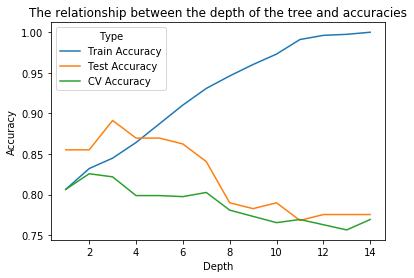

In [24]:
accuracies = pd.DataFrame( 
    data = accuracies, 
    columns = ['Depth', 'Train Accuracy','Test Accuracy', 'CV Accuracy']
)    

accuracies = pd.melt(
    accuracies,
    id_vars = ['Depth'],
    var_name = 'Type',
    value_name = 'Accuracy'
) 
sns.lineplot(
    x = 'Depth',
    y = 'Accuracy',
    hue = 'Type',
    data = accuracies,

).set_title('The relationship between the depth of the tree and accuracies')

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        62
           1       0.77      0.80      0.79        76

    accuracy                           0.76       138
   macro avg       0.76      0.76      0.76       138
weighted avg       0.76      0.76      0.76       138



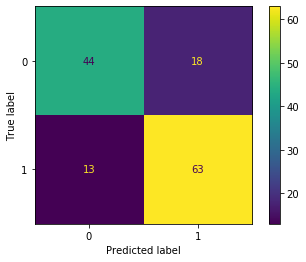

In [25]:
plot_confusion_matrix(tree_clf, X_test, y_test)
print(classification_report(y_test, y_pred))

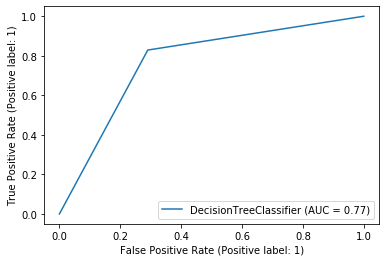

In [26]:
plot_roc_curve(tree_clf, X_test, y_test, response_method='auto')

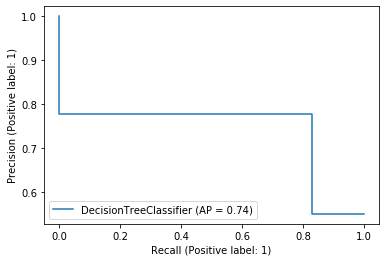

In [27]:
plot_precision_recall_curve(tree_clf, X_test, y_test)

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.7561544991511037

# 2.Logistic Regression


In [29]:
log = LogisticRegression(random_state=101, class_weight=None, solver='liblinear')
log.fit(X_train, y_train)
y_pred = log.predict(X_test)


In [30]:
print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101, solver='liblinear')


In [31]:
log.score(X_train, y_train)

0.8705128205128205

In [32]:

y_train_pred = log.predict(X_train)

In [33]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[53  9]
 [ 8 68]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        62
           1       0.88      0.89      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.88       138
weighted avg       0.88      0.88      0.88       138



[[53  9]
 [ 8 68]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        62
           1       0.88      0.89      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.88       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


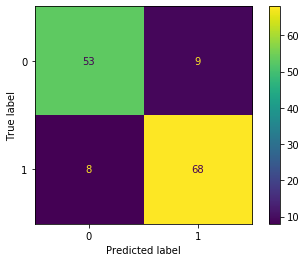

In [34]:


print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(log, X_test, y_test)



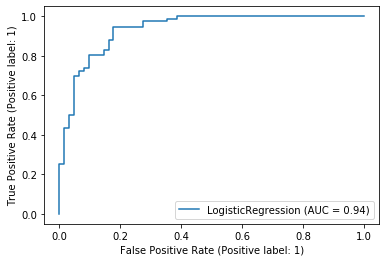

In [35]:
plot_roc_curve(log, X_test_scaled, y_test, response_method='auto')

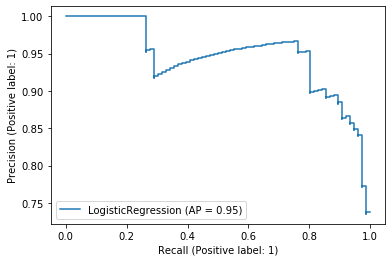

In [36]:
plot_precision_recall_curve(log, X_test, y_test)

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8747877758913414

# 3. Support Vector Machine (SVM)

SVM provides three kernels: linear, polynomial and rbf. We use `GridSearchCV` to select the best parameters for the support vectore classifier. The result is `kernel='linear'` and `C=10`. We can ignore degree and gamma because they are only used in poly and rbf kernel. The higest accuracy <b>0.8560</b> is a model performed with cross-validation.

[[54  8]
 [ 7 69]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.90      0.91      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138

--------------------------------------------------------


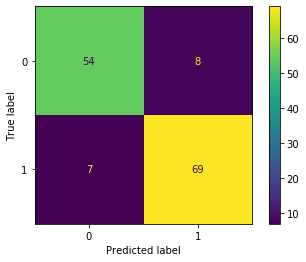

In [38]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train_scaled, y_train)
y_pred = SVM_model.predict(X_test_scaled)
y_train_pred = SVM_model.predict(X_train_scaled)

svm_f1 = f1_score(y_test, y_pred)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_test_scaled, y_test)


In [39]:
svm_xvalid_model = SVC()

svm_xvalid_model_scores = cross_validate(svm_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
svm_xvalid_model_scores = pd.DataFrame(svm_xvalid_model_scores, index = range(1, 11))

svm_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.014442,0.003869,0.833333,0.800000,0.930233,0.860215
2,0.013798,0.003779,0.820513,0.808511,0.883721,0.844444
3,0.013839,0.003520,0.858974,0.880952,0.860465,0.870588
4,0.013154,0.003918,0.820513,0.837209,0.837209,0.837209
5,0.013853,0.003699,0.923077,0.951220,0.906977,0.928571
6,0.012898,0.003518,0.794872,0.800000,0.837209,0.818182
7,0.013725,0.003693,0.884615,0.854167,0.953488,0.901099
8,0.013421,0.003526,0.858974,0.847826,0.906977,0.876404
9,0.013313,0.003567,0.833333,0.897436,0.795455,0.843373
10,0.013716,0.003591,0.923077,0.913043,0.954545,0.933333


In [40]:
svm_xvalid_model_scores.mean()[2:]

test_accuracy     0.855128
test_precision    0.859036
test_recall       0.886628
test_f1           0.871342
dtype: float64

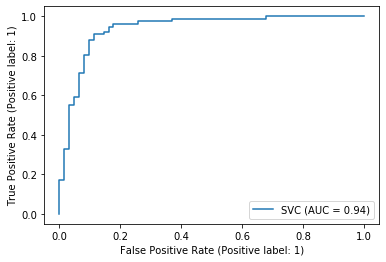

In [41]:
plot_roc_curve(SVM_model, X_test_scaled, y_test)

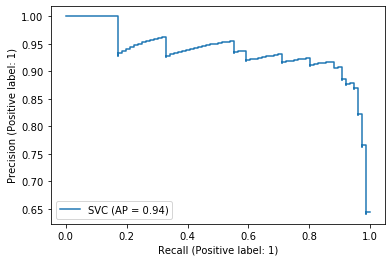

In [42]:
plot_precision_recall_curve(SVM_model, X_test_scaled, y_test)

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8894312393887946

In [44]:
SVM2 = SVC(gamma='scale',decision_function_shape='ovo')
SVM2.fit(X_train,y_train)
svm_explainer = shap.KernelExplainer(SVM2.predict,X_test)
svm_shap_values = svm_explainer.shap_values(X_test)

Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 138/138 [38:10<00:00, 16.60s/it]


# 4. KNN

[[50 12]
 [10 66]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        62
           1       0.85      0.87      0.86        76

    accuracy                           0.84       138
   macro avg       0.84      0.84      0.84       138
weighted avg       0.84      0.84      0.84       138

--------------------------------------------------------


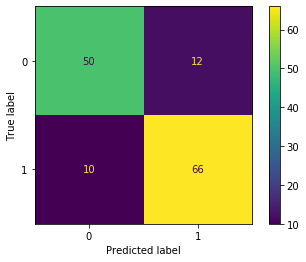

In [45]:
KNN_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
KNN_model.fit(X_train_scaled, y_train)
y_pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn_f1 = f1_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)



In [46]:
y_pred_proba = KNN_model.predict_proba(X_test_scaled)

In [47]:
pd.DataFrame(y_pred_proba)

,0,1
0,0.0,1.0
1,0.2,0.8
2,0.2,0.8
3,0.8,0.2
4,0.4,0.6
...,...,...
133,0.8,0.2
134,1.0,0.0
135,0.6,0.4
136,0.0,1.0


In [48]:
my_dict = {"Actual": y_test, "Pred": y_pred, "Proba_1": y_pred_proba[:,1], "Proba_0":y_pred_proba[:,0]}

In [49]:
pd.DataFrame.from_dict(my_dict).sample(10)

,Actual,Pred,Proba_1,Proba_0
335,1,0,0.4,0.6
502,1,1,1.0,0.0
410,1,1,1.0,0.0
400,1,1,1.0,0.0
61,0,0,0.0,1.0
462,1,1,1.0,0.0
17,0,0,0.0,1.0
395,1,1,1.0,0.0
169,0,0,0.0,1.0
790,1,1,0.8,0.2


In [50]:
knn_xvalid_model = KNeighborsClassifier(n_neighbors=5)

knn_xvalid_model_scores = cross_validate(knn_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
knn_xvalid_model_scores = pd.DataFrame(knn_xvalid_model_scores, index = range(1, 11))

knn_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.001412,0.004092,0.807692,0.791667,0.883721,0.835165
2,0.000882,0.003818,0.858974,0.833333,0.930233,0.879121
3,0.000673,0.003595,0.923077,0.930233,0.930233,0.930233
4,0.000660,0.003654,0.820513,0.837209,0.837209,0.837209
5,0.000672,0.003587,0.923077,0.893617,0.976744,0.933333
6,0.000637,0.003555,0.820513,0.822222,0.860465,0.840909
7,0.000626,0.003564,0.871795,0.836735,0.953488,0.891304
8,0.000627,0.003984,0.858974,0.847826,0.906977,0.876404
9,0.000806,0.003918,0.833333,0.897436,0.795455,0.843373
10,0.000735,0.003579,0.935897,0.914894,0.977273,0.945055


In [51]:
knn_xvalid_model_scores.mean()[2:]

test_accuracy     0.865385
test_precision    0.860517
test_recall       0.905180
test_f1           0.881211
dtype: float64

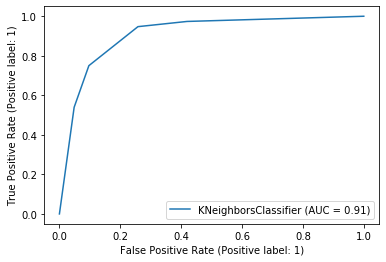

In [52]:
plot_roc_curve(KNN_model, X_test_scaled, y_test)

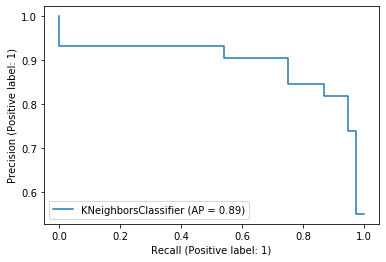

In [53]:
plot_precision_recall_curve(KNN_model, X_test_scaled, y_test)

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8374363327674023

# 5. AdaBoost

[[52 10]
 [ 7 69]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        62
           1       0.87      0.91      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


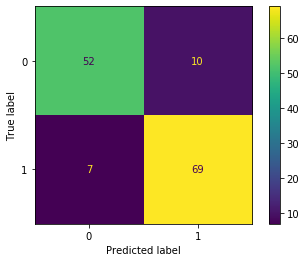

In [55]:
AB_model = AdaBoostClassifier(n_estimators=50, random_state=101)
AB_model.fit(X_train, y_train)
y_pred = AB_model.predict(X_test)
y_train_pred = AB_model.predict(X_train)

ab_f1 = f1_score(y_test, y_pred)
ab_acc = accuracy_score(y_test, y_pred)
ab_recall = recall_score(y_test, y_pred)
ab_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_test, y_test)



In [56]:
ab_xvalid_model = AdaBoostClassifier(n_estimators=50, random_state=101)

ab_xvalid_model_scores = cross_validate(ab_xvalid_model, X_train, y_train, scoring = ['accuracy', 'precision','recall', 'f1'], cv = 10)
ab_xvalid_model_scores = pd.DataFrame(ab_xvalid_model_scores, index = range(1, 11))

ab_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.044586,0.005628,0.782051,0.795455,0.813953,0.804598
2,0.043753,0.005592,0.807692,0.833333,0.813953,0.823529
3,0.043880,0.005530,0.871795,0.883721,0.883721,0.883721
4,0.047384,0.006028,0.794872,0.813953,0.813953,0.813953
5,0.045800,0.005555,0.833333,0.840909,0.860465,0.850575
6,0.043142,0.005687,0.833333,0.857143,0.837209,0.847059
7,0.042773,0.005360,0.923077,0.893617,0.976744,0.933333
8,0.042471,0.005419,0.833333,0.857143,0.837209,0.847059
9,0.043810,0.005512,0.833333,0.878049,0.818182,0.847059
10,0.043527,0.005526,0.923077,0.931818,0.931818,0.931818


In [57]:
ab_xvalid_model_scores.mean()

fit_time          0.044113
score_time        0.005584
test_accuracy     0.843590
test_precision    0.858514
test_recall       0.858721
test_f1           0.858270
dtype: float64

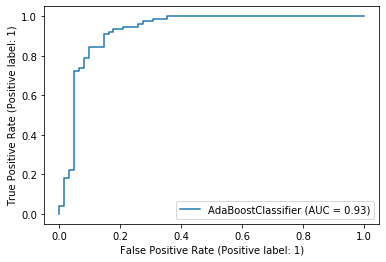

In [58]:
plot_roc_curve(AB_model, X_test, y_test)

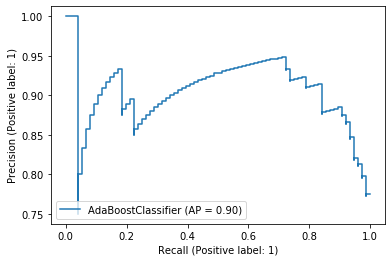

In [59]:
plot_precision_recall_curve(AB_model, X_test, y_test)

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8733022071307301

# 6. XGBoost

[[55  7]
 [ 9 67]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        62
           1       0.91      0.88      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

--------------------------------------------------------


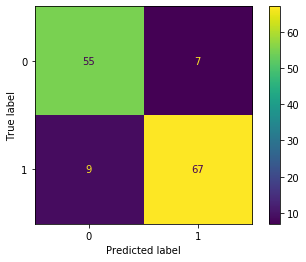

In [61]:
XGB_model = XGBClassifier(random_state=101)
XGB_model.fit(X_train_scaled, y_train)
y_pred = XGB_model.predict(X_test_scaled)
y_train_pred = XGB_model.predict(X_train_scaled)

xgb_f1 = f1_score(y_test, y_pred)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_model, X_test_scaled, y_test)


In [62]:
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.109943,0.002749,0.820513,0.837209,0.837209,0.837209
2,0.098567,0.003090,0.756410,0.772727,0.790698,0.781609
3,0.112863,0.002769,0.897436,0.888889,0.930233,0.909091
4,0.091146,0.003261,0.846154,0.860465,0.860465,0.860465
5,0.097521,0.002881,0.846154,0.878049,0.837209,0.857143
6,0.101161,0.002849,0.884615,0.854167,0.953488,0.901099
7,0.092091,0.002678,0.846154,0.816327,0.930233,0.869565
8,0.087490,0.002662,0.820513,0.837209,0.837209,0.837209
9,0.123449,0.002784,0.807692,0.871795,0.772727,0.819277
10,0.108926,0.002740,0.897436,0.891304,0.931818,0.911111


In [63]:
xgb_xvalid_model_scores.mean()

fit_time          0.102316
score_time        0.002846
test_accuracy     0.842308
test_precision    0.850814
test_recall       0.868129
test_f1           0.858378
dtype: float64

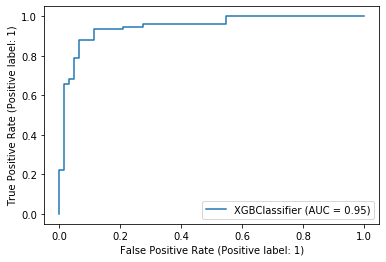

In [64]:
plot_roc_curve(XGB_model, X_test_scaled, y_test);

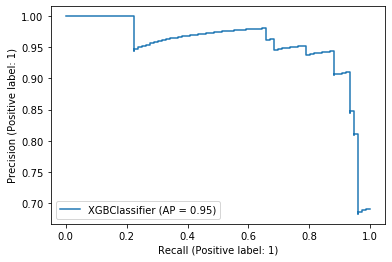

In [65]:
plot_precision_recall_curve(XGB_model, X_test_scaled, y_test);

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8843378607809848

# Explaining the model

## Permutation Tables

In [67]:
perm = PermutationImportance(log, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0420 ± 0.0393,ST_Slope_Flat
0.0188 ± 0.0235,ChestPainType_NAP
0.0188 ± 0.0148,Oldpeak
0.0188 ± 0.0116,Sex_M
0.0174 ± 0.0148,ST_Slope_Up
0.0159 ± 0.0108,Cholesterol
0.0145 ± 0.0275,FastingBS
0.0130 ± 0.0142,ChestPainType_ATA
0.0072 ± 0.0159,ExerciseAngina_Y
0.0072 ± 0.0130,ChestPainType_TA


In [68]:
perm = PermutationImportance(tree_clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0609 ± 0.0395,ST_Slope_Up
0.0275 ± 0.0232,Oldpeak
0.0275 ± 0.0404,MaxHR
0.0246 ± 0.0148,Sex_M
0.0217 ± 0.0092,RestingBP
0.0188 ± 0.0148,ChestPainType_ATA
0.0145 ± 0.0259,FastingBS
0.0072 ± 0.0130,ChestPainType_NAP
0.0072 ± 0.0205,Cholesterol
0.0029 ± 0.0338,ExerciseAngina_Y


In [69]:

perm = PermutationImportance(SVM2, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1058 ± 0.0605,Cholesterol
0.0855 ± 0.0886,MaxHR
0.0304 ± 0.0142,RestingBP
0.0058 ± 0.0249,Age
0 ± 0.0000,ST_Slope_Up
0 ± 0.0000,ST_Slope_Flat
0 ± 0.0000,ExerciseAngina_Y
0 ± 0.0000,RestingECG_ST
0 ± 0.0000,RestingECG_Normal
0 ± 0.0000,ChestPainType_TA


In [70]:
perm = PermutationImportance(KNN_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0232 ± 0.0323,MaxHR
0.0203 ± 0.0281,ST_Slope_Up
0.0174 ± 0.0116,ST_Slope_Flat
0.0145 ± 0.0092,FastingBS
0.0101 ± 0.0071,Sex_M
0.0029 ± 0.0071,ChestPainType_NAP
0.0029 ± 0.0071,Oldpeak
0 ± 0.0000,RestingECG_ST
0 ± 0.0000,ChestPainType_TA
-0.0029 ± 0.0071,ChestPainType_ATA


In [71]:

perm = PermutationImportance(AB_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0609 ± 0.0385,ST_Slope_Up
0.0406 ± 0.0269,ChestPainType_ATA
0.0333 ± 0.0338,Cholesterol
0.0304 ± 0.0169,Sex_M
0.0217 ± 0.0259,ChestPainType_NAP
0.0188 ± 0.0197,Oldpeak
0.0159 ± 0.0108,MaxHR
0.0145 ± 0.0159,ST_Slope_Flat
0.0145 ± 0.0092,FastingBS
0.0058 ± 0.0249,ExerciseAngina_Y


In [72]:

perm = PermutationImportance(XGB_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0986 ± 0.0116,ST_Slope_Flat
0.0739 ± 0.0296,Oldpeak
0.0391 ± 0.0235,ChestPainType_NAP
0.0391 ± 0.0197,Sex_M
0.0319 ± 0.0298,RestingECG_Normal
0.0072 ± 0.0205,ST_Slope_Up
0.0029 ± 0.0148,FastingBS
0.0014 ± 0.0404,Cholesterol
0 ± 0.0000,RestingECG_ST
0 ± 0.0000,MaxHR


## Partial Dependence Plot

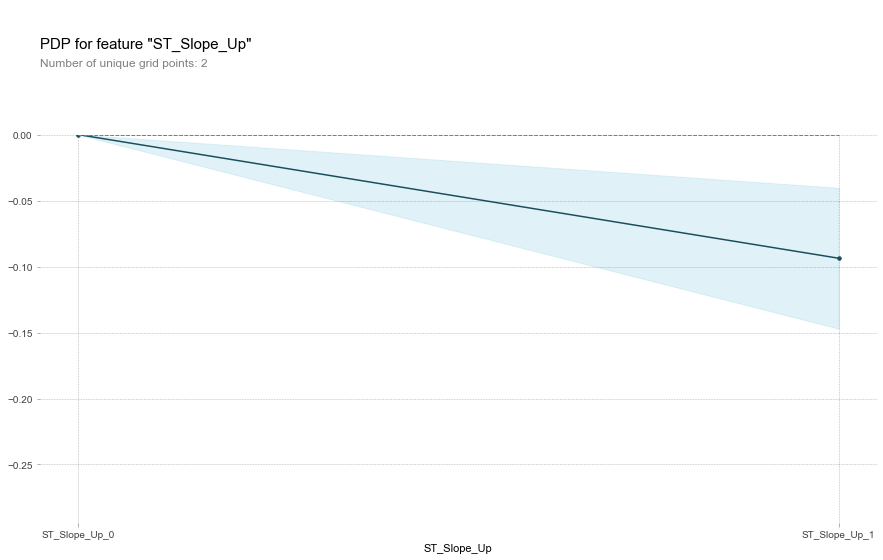

In [73]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'ST_Slope_Up'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

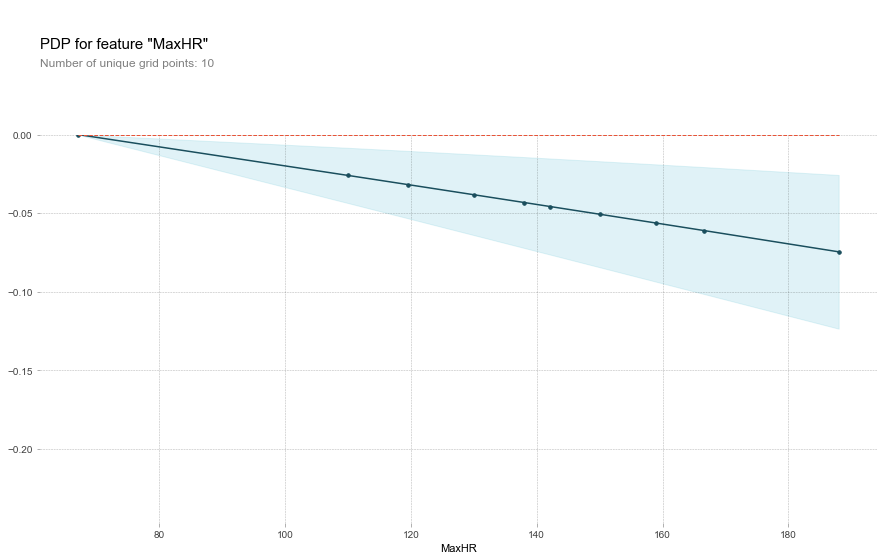

In [74]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'MaxHR'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

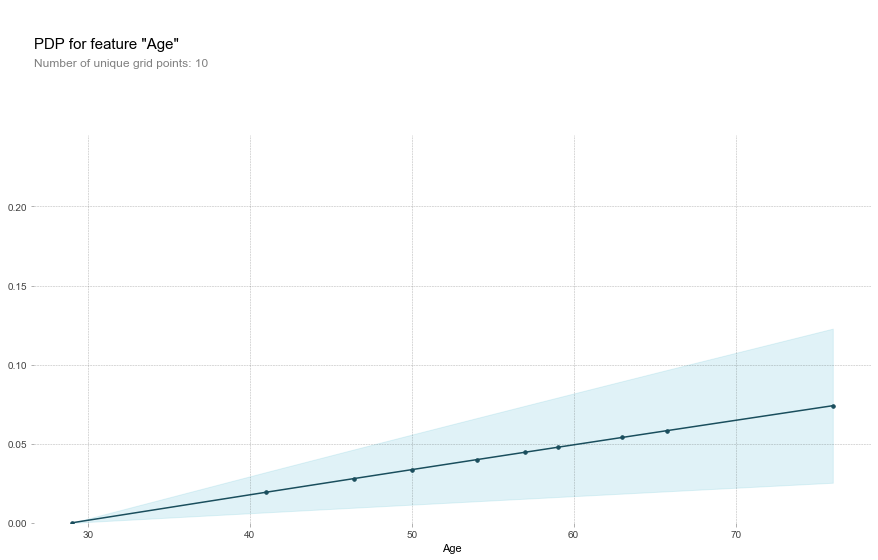

In [75]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Age'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

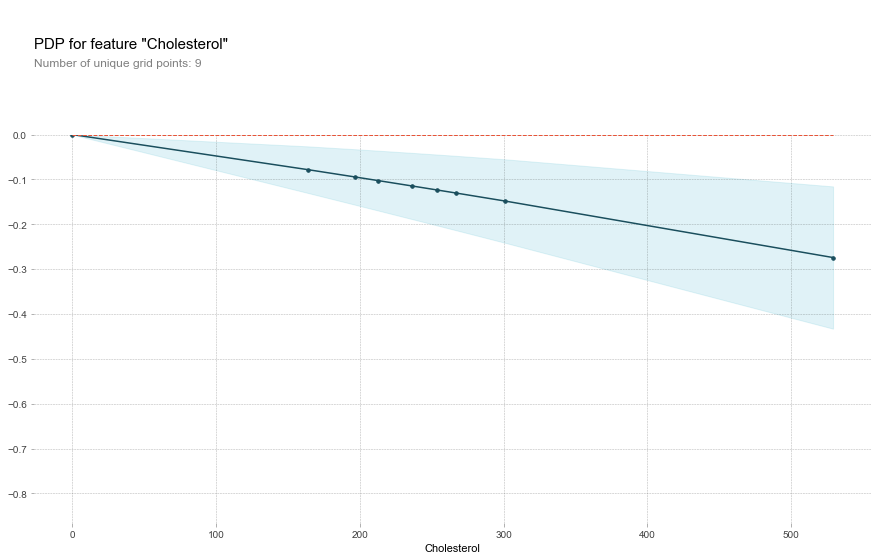

In [76]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Cholesterol'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

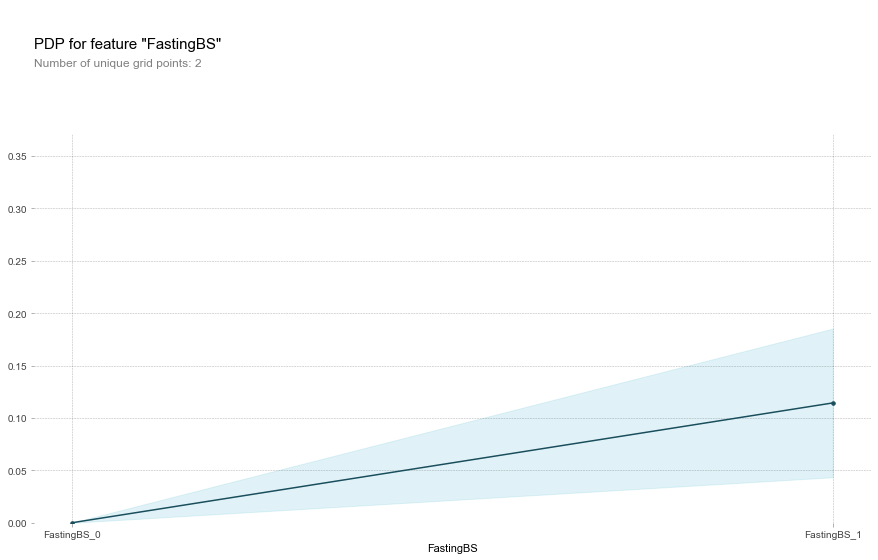

In [77]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'FastingBS'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

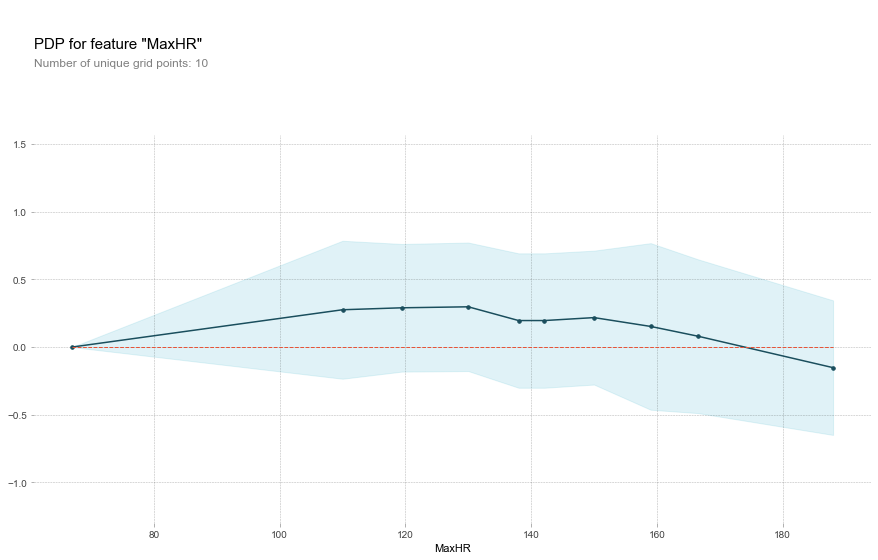

In [78]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'MaxHR'
pdp_dist = pdp.pdp_isolate(model=tree_clf, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

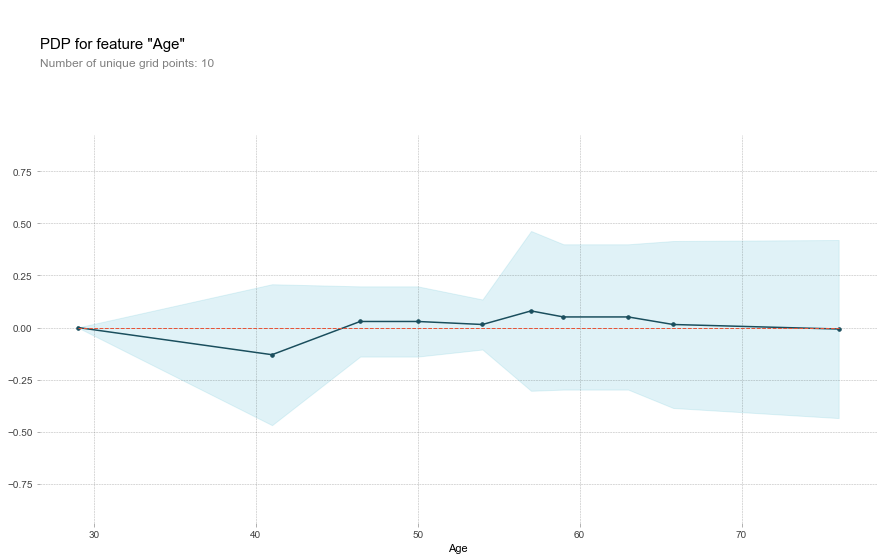

In [79]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Age'
pdp_dist = pdp.pdp_isolate(model=tree_clf, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

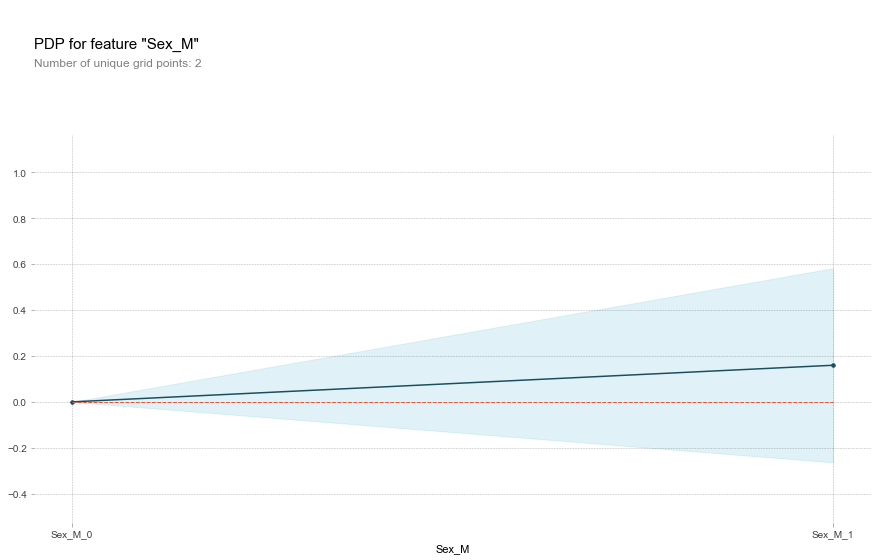

In [80]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Sex_M'
pdp_dist = pdp.pdp_isolate(model=tree_clf, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

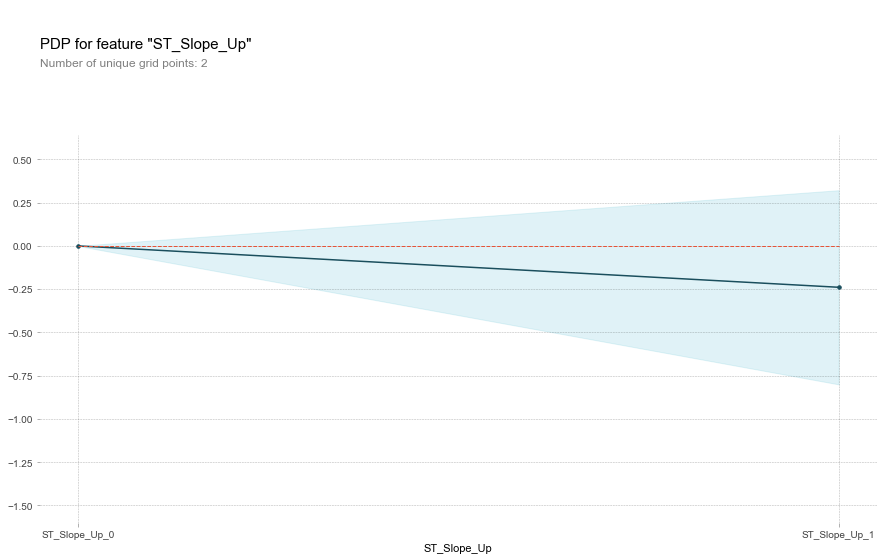

In [81]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'ST_Slope_Up'
pdp_dist = pdp.pdp_isolate(model=tree_clf, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

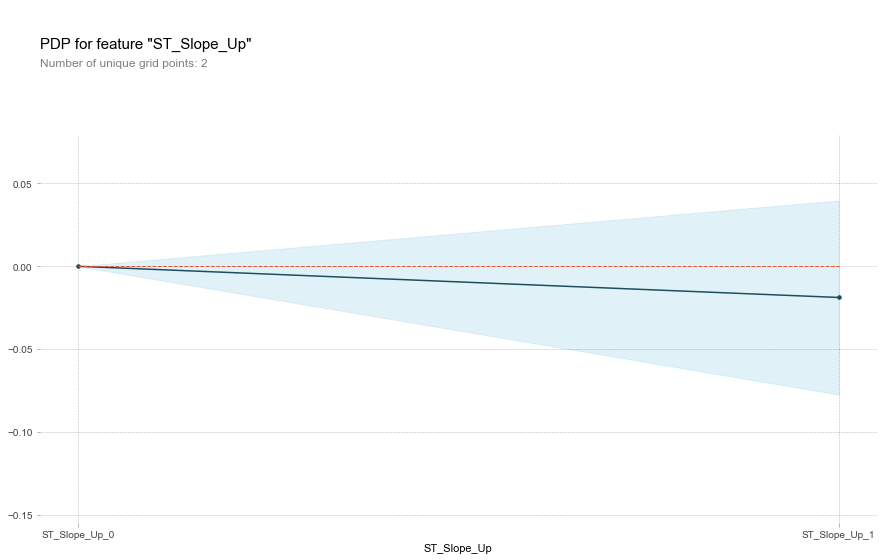

In [82]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'ST_Slope_Up'
pdp_dist = pdp.pdp_isolate(model=KNN_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

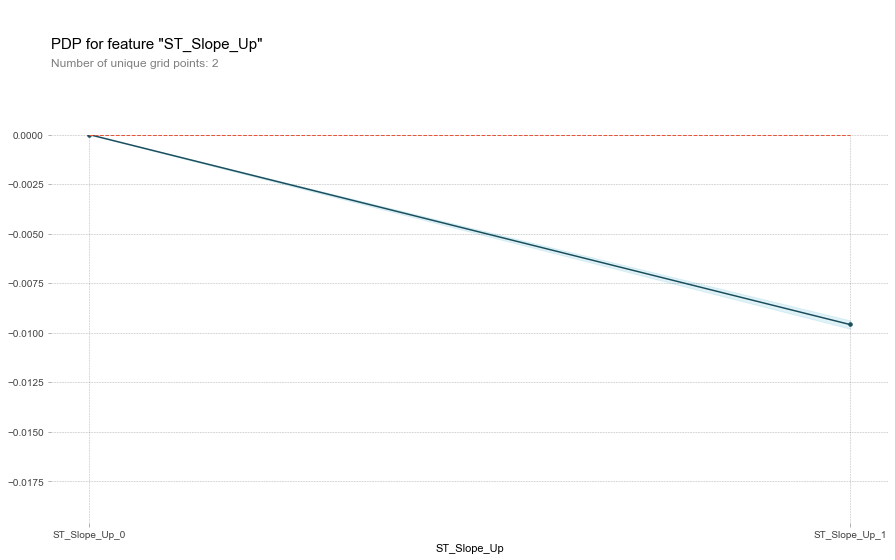

In [83]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'ST_Slope_Up'
pdp_dist = pdp.pdp_isolate(model=AB_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

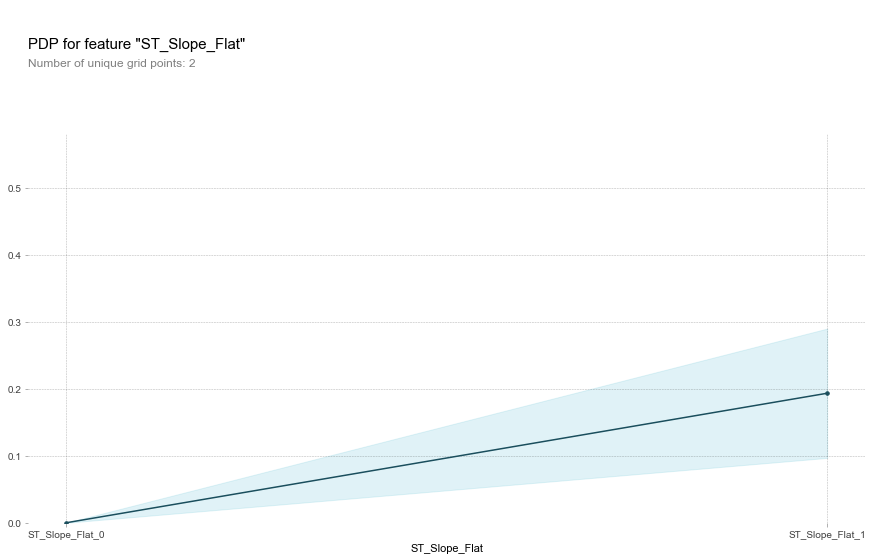

In [84]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'ST_Slope_Flat'
pdp_dist = pdp.pdp_isolate(model=log, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

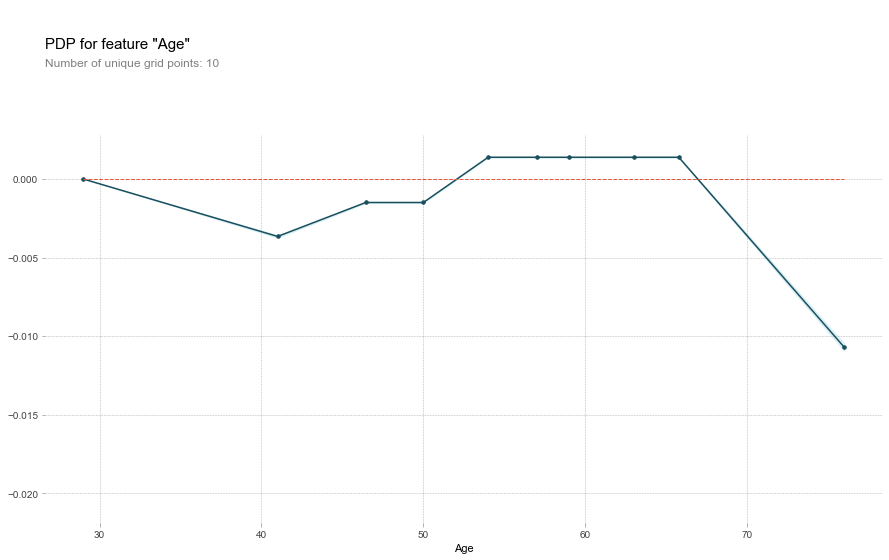

In [85]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Age'
pdp_dist = pdp.pdp_isolate(model=AB_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

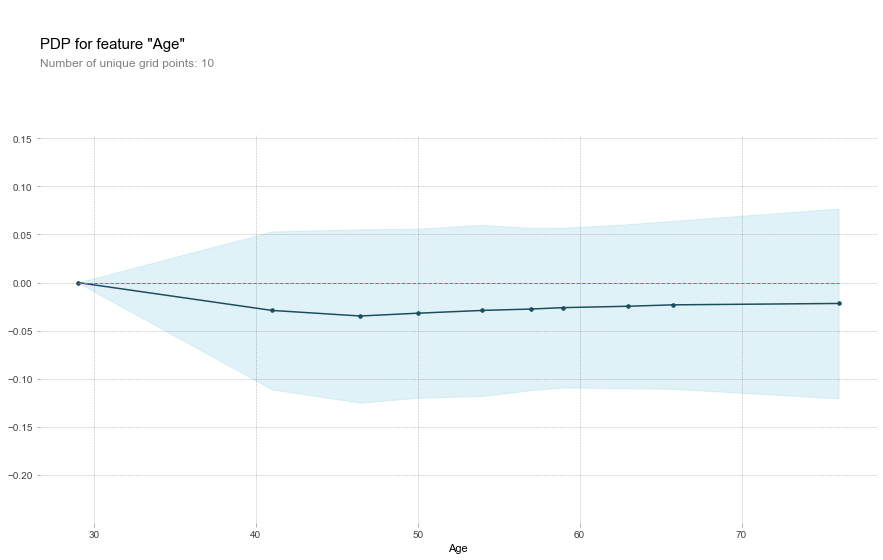

In [86]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'Age'
pdp_dist = pdp.pdp_isolate(model=KNN_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

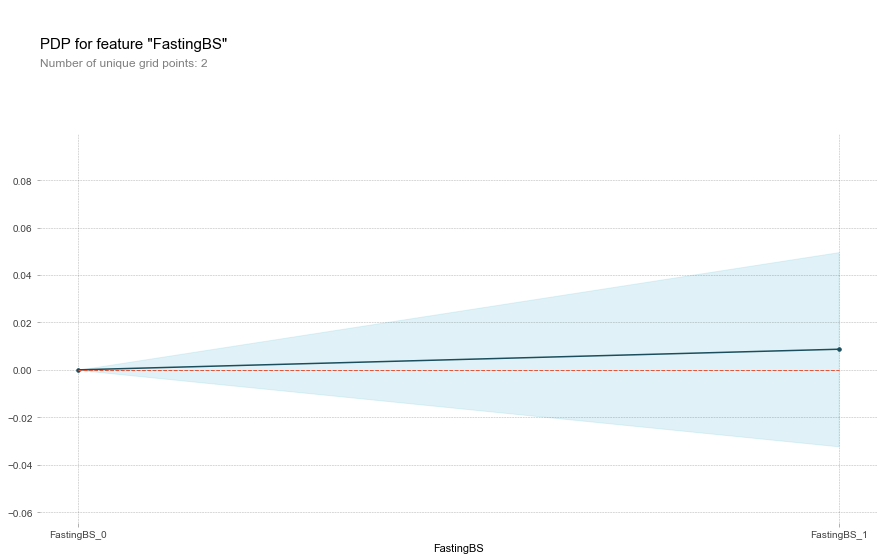

In [87]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'FastingBS'
pdp_dist = pdp.pdp_isolate(model=KNN_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

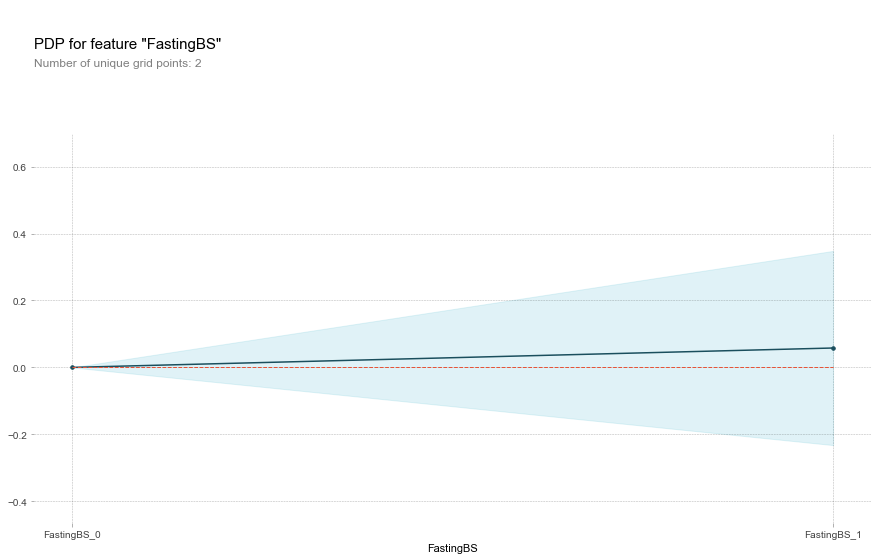

In [88]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'FastingBS'
pdp_dist = pdp.pdp_isolate(model=tree_clf, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

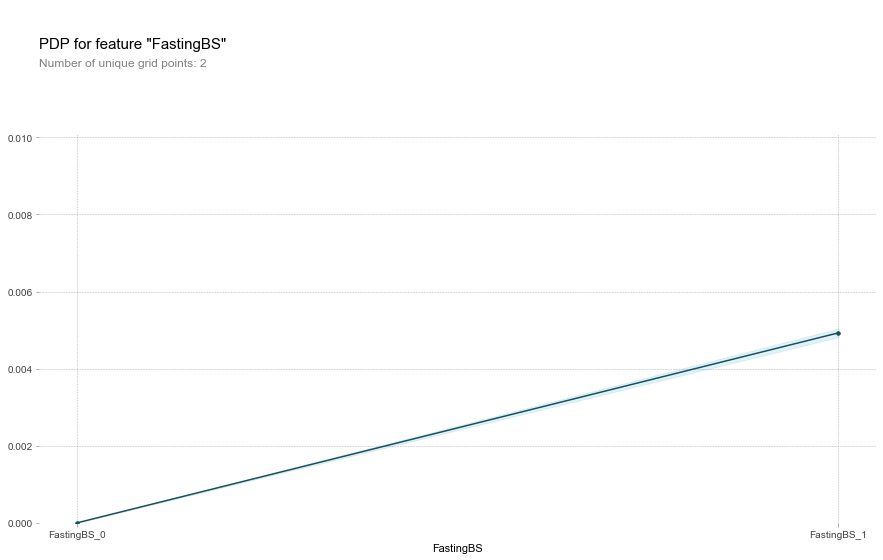

In [89]:
base_features = data.columns.values.tolist()
base_features.remove('HeartDisease')

feat_name = 'FastingBS'
pdp_dist = pdp.pdp_isolate(model=AB_model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

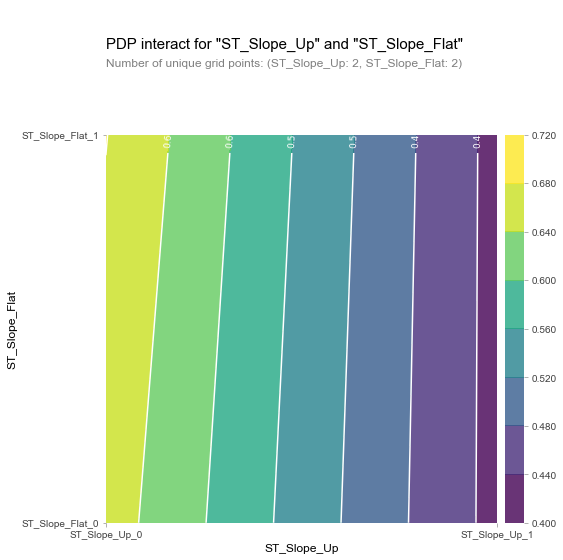

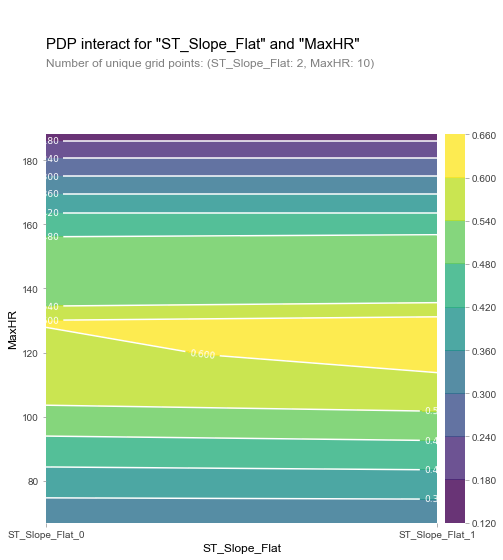

In [90]:
inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['ST_Slope_Up', 'ST_Slope_Flat'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['ST_Slope_Up', 'ST_Slope_Flat'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['ST_Slope_Flat', 'MaxHR'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['ST_Slope_Flat', 'MaxHR'], plot_type='contour')
plt.show()

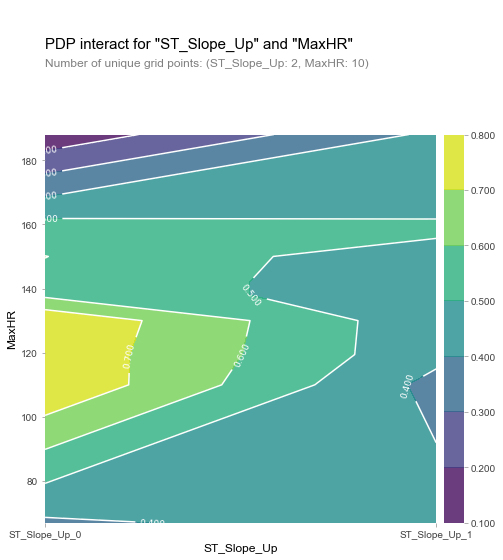

In [91]:
inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['ST_Slope_Up', 'MaxHR'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['ST_Slope_Up', 'MaxHR'], plot_type='contour')
plt.show()

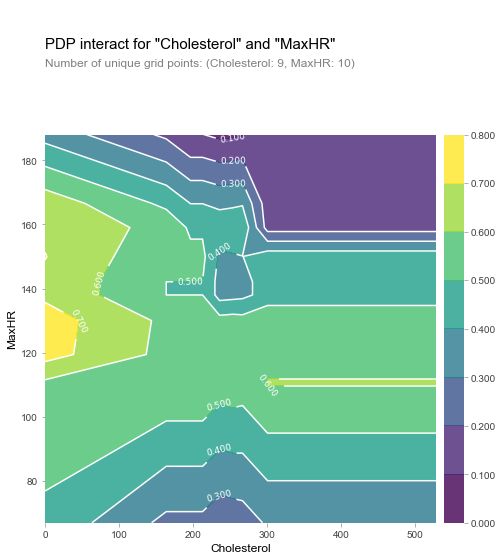

In [92]:
inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['Cholesterol', 'MaxHR'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Cholesterol', 'MaxHR'], plot_type='contour')
plt.show()

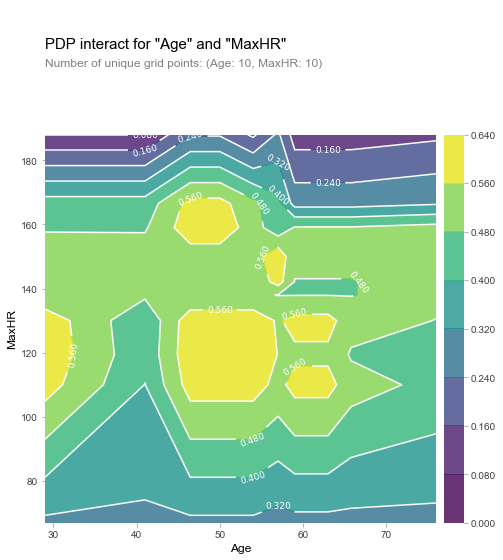

In [93]:
inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['Age', 'MaxHR'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Age', 'MaxHR'], plot_type='contour')
plt.show()

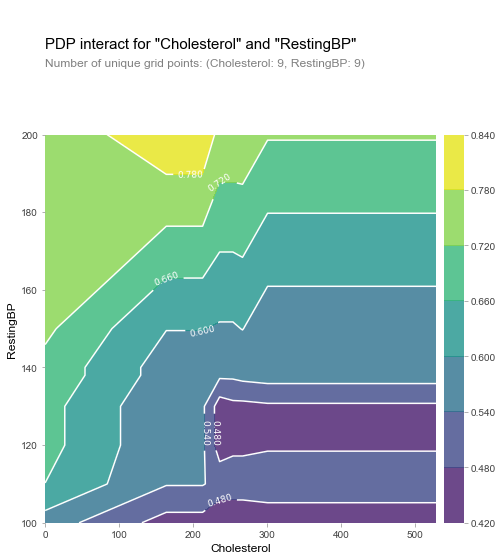

In [94]:
inter1  =  pdp.pdp_interact(model=tree_clf, dataset=X_test, model_features=base_features, features=['Cholesterol', 'RestingBP'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Cholesterol', 'RestingBP'], plot_type='contour')
plt.show()

## Summary Plots

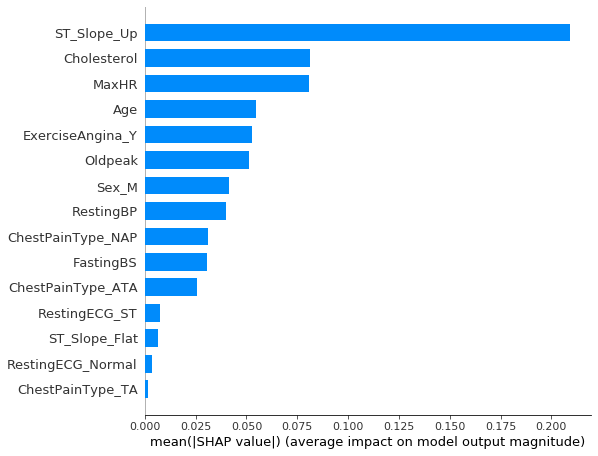

In [95]:
tree_explainer = shap.TreeExplainer(tree_clf)
tree_shap_values = tree_explainer.shap_values(X_test)

shap.summary_plot(tree_shap_values[1], X_test, plot_type="bar")

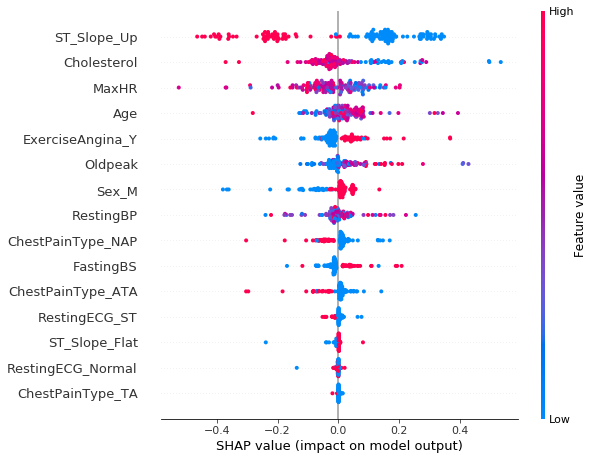

In [96]:
shap.summary_plot(tree_shap_values[1], X_test)

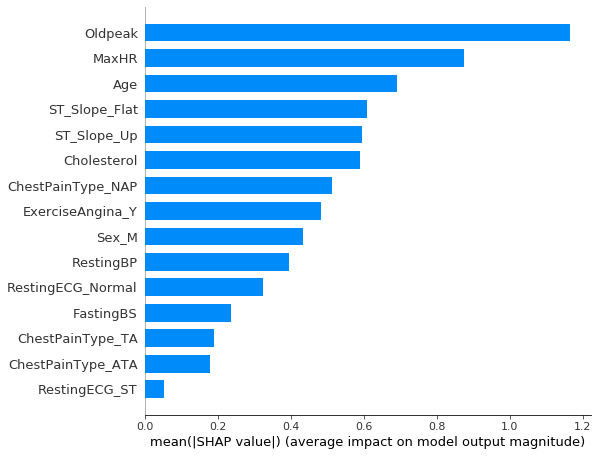

In [97]:
xgb_explainer = shap.Explainer(XGB_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)


shap.summary_plot(xgb_shap_values, X_test, plot_type="bar")


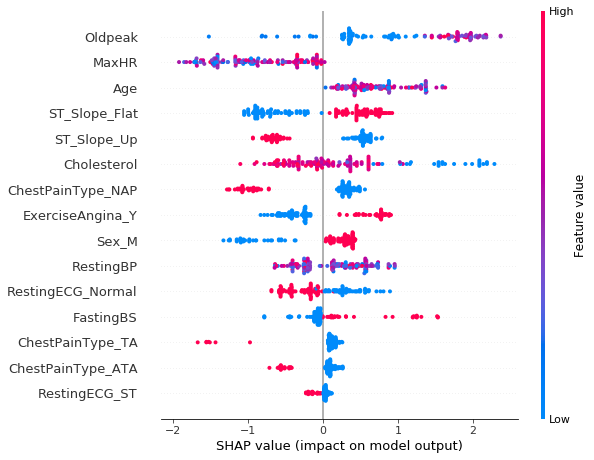

In [98]:
shap.summary_plot(xgb_shap_values, X_test)


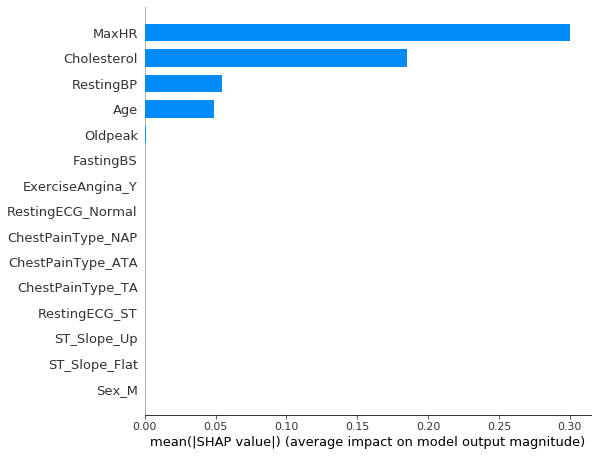

In [99]:
shap.summary_plot(svm_shap_values, X_test, plot_type="bar")

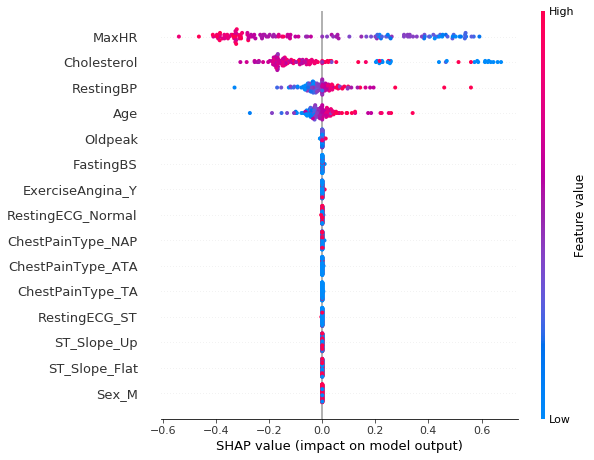

In [100]:
shap.summary_plot(svm_shap_values, X_test)

In [101]:
#KNN_model = KNeighborsClassifier(n_neighbors=5)
#KNN_model.fit(X_train_scaled, y_train)
#knn_explainer = shap.KernelExplainer(KNN_model.predict,X_train_scaled)
#knn_shap_values = knn_explainer.shap_values(X_test)
#shap.summary_plot(knn_shap_values, X_test)#

In [102]:
shap.sample(data, 5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
684,47,108,243,0,152,0.0,1,1,0,1,0,1,0,0,0,1
559,64,134,273,0,102,4.0,1,1,0,0,0,1,0,1,0,0
629,57,128,303,0,159,0.0,0,0,0,0,0,0,0,0,0,1
192,48,130,245,0,160,0.0,0,1,1,0,0,1,0,0,0,1
835,54,110,239,0,126,2.8,1,1,0,0,0,1,0,1,1,0


####################################################################################################################################################

## Individual Force Plots

In [103]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [104]:
#Decision_Tree
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(tree_clf, data_for_prediction)

In [105]:
data_for_prediction = X_test.iloc[20,:].astype(float)
heart_disease_risk_factors(tree_clf, data_for_prediction)

In [106]:

shap.force_plot(xgb_explainer.expected_value,xgb_shap_values[10,:], X_test.iloc[10,:])

In [107]:
shap.force_plot(xgb_explainer.expected_value,xgb_shap_values[35,:], X_test.iloc[35,:])

In [108]:
shap.force_plot(svm_explainer.expected_value,svm_shap_values[10,:], X_test.iloc[10,:])

In [109]:
shap.force_plot(svm_explainer.expected_value,svm_shap_values[6,:], X_test.iloc[6,:])

## Collective Force Plots

In [110]:
shap_values = xgb_explainer.shap_values(X_train.iloc[:50])
shap.force_plot(xgb_explainer.expected_value, shap_values, X_test.iloc[:50])

In [111]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values, X_test)